In [1]:
# Transfer Learning (Classical cum Quantum)

In [2]:
# OpenMP: number of parallel threads.
%env OMP_NUM_THREADS=1

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

# Other tools
import time
import os
import copy

env: OMP_NUM_THREADS=1


Configuration of the network model's primary parameters and the training process. Note: To replicate the outcomes described in [the paper], set num_epochs to 30, which could require several hours. As a preliminary test, we recommend starting with num_epochs=1 to ensure all components function correctly.

In [22]:
# Seed for random number generator to ensure reproducibility
rng_seed = 0

# Determines if a quantum or classical model is used
quantum = True

# Specifies the type of classical model to use when not using a quantum circuit
classical_model = '512_nq_2'    

# Defines the number of qubits used in the quantum model
n_qubits = 4

# Sets the depth of the quantum circuit (number of variational layers)
q_depth = 6

# Number of training epochs
num_epochs = 30

# Learning rate for the optimizer
step = 0.0004

# Learning rate reduction factor, applied every 10 epochs
gamma_lr_scheduler = 0.1

# Batch size for each training step
batch_size = 4

# Maximum number of layers; not all may be used
max_layers = 15

# Initial spread of random quantum weights
q_delta = 0.01

# Marks the start time of the computation
start_time = time.time()


Let us initialize a PennyLane device with the default simulator.

In [20]:
dev = qml.device('default.qubit', wires=n_qubits)

Configure PyTorch to use CUDA, only if available. Otherwise simply use the CPU.

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Loading the Dataset
Note: The dataset includes images of ants and bees.
It comprises a small collection of approximately 200 images, insufficient for training a deep neural network from scratch but adequate for implementing a transfer learning strategy.

We utilize the PyTorch modules torchvision and torch.utils.data for dataset loading and to conduct basic image preprocessing tasks such as resizing, centering, cropping, normalizing, etc..

In [6]:
# Dictionary of transformations to apply to the dataset images during preprocessing.
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),  # Resize the image to 256x256 pixels
        transforms.CenterCrop(224),  # Crop the image to 224x224 pixels from the center
        transforms.ToTensor(),  # Convert the image to a PyTorch tensor
        # Normalize each channel of the tensor to match the ImageNet distribution
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),  # Resize the image to 256x256 pixels
        transforms.CenterCrop(224),  # Crop the image to 224x224 pixels from the center
        transforms.ToTensor(),  # Convert the image to a PyTorch tensor
        # Normalize each channel of the tensor to match the ImageNet distribution
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Directory containing the training and validation dataset
data_dir = 'hymenoptera_data'
# Load datasets using the specified directory and transformations
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                     data_transforms[x]) for x in ['train', 'val']}
# Determine the size of each dataset
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# Retrieve class names from the training dataset
class_names = image_datasets['train'].classes

# Initialize dataloaders for batch processing of datasets, enabling random shuffling
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                  batch_size=batch_size, shuffle=True) for x in ['train', 'val']}

# Function to display an image
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))  # Convert the tensor format to image format
    # Reverse the normalization for visualization
    mean = np.array([0.485, 0.456, 0.406])  # Mean used in normalization
    std = np.array([0.229, 0.224, 0.225])  # Standard deviation used in normalization
    inp = std * inp + mean  # Apply the reverse of normalization
    inp = np.clip(inp, 0, 1)  # Clip values to be between 0 and 1
    plt.imshow(inp)  # Show the image
    if title is not None:
        plt.title(title)  # Optionally set a title if provided


seeing sample inputs


In [7]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


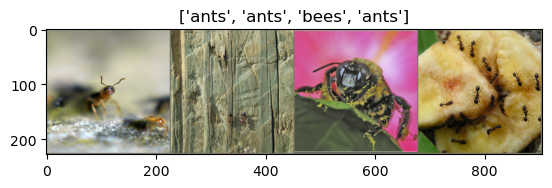

In [8]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

To ensure consistent and reproducible outcomes, we manually set a seed for the random number generator and reset the dataloaders.

In [9]:
torch.manual_seed(rng_seed)
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                  batch_size=batch_size,shuffle=True) for x in ['train', 'val']}

## Hybrid transfer learning model (classical-to-quantum).

We first define some quantum layers that will compose the quantum circuit.

In [10]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    Apply a Hadamard gate to each qubit in the circuit. This gate creates a superposition state,
    setting the stage for quantum computations.
    """
    for idx in range(nqubits):  # Loop over all qubits
        qml.Hadamard(wires=idx)  # Apply Hadamard gate to each qubit individually

def RY_layer(w):
    """Layer of parametrized qubit rotations around the y-axis.
    This function applies a rotation to each qubit based on the provided parameter,
    allowing for variational tuning in a quantum algorithm.
    """
    for idx, element in enumerate(w):  # Loop over each weight and corresponding qubit
        qml.RY(element, wires=idx)  # Apply rotation around the y-axis by 'element' radians

def entangling_layer(nqubits):
    """Layer of CNOT gates arranged in a staggered pattern to entangle qubits.
    First, a row of CNOT gates connects pairs of qubits sequentially. Then,
    another row shifts to connect the next pairs, creating a network of entanglements.
    """
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])  # Apply CNOT between pair of qubits
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices: i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])  # Apply CNOT between next pair of qubits


Let us define the quantum circuit by using the PennyLane `qnode` decorator . The structure is that of a typical variational quantum circuit:
1. All qubits are first initialized in a balanced superposition of *up* and *down* states, then they are rotated according to the input parameters (local embedding);
2. Successively a sequence of trainable rotation layers and constant entangling layers is applied. This block is responsible for the main computation necessary to solve the classification problem.
3. Eventually, for each qubit, the local expectation value of the Z operator is measured. This produces a classical output vector, suitable for additional post-processing.

In [11]:
@qml.qnode(dev, interface='torch')
def q_net(q_in, q_weights_flat):
        
        # Reshape weights
        q_weights = q_weights_flat.reshape(max_layers, n_qubits)
        
        # Start from state |+> , unbiased w.r.t. |0> and |1>
        H_layer(n_qubits)   
        
        # Embed features in the quantum node
        RY_layer(q_in)      
       
        # Sequence of trainable variational layers
        for k in range(q_depth):
            entangling_layer(n_qubits)
            RY_layer(q_weights[k + 1])

        # Expectation values in the Z basis
        return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]

We can now define a custom `torch.nn.Module` representing a *dressed* quantum circuit.<br>
This is is a concatenation of:
1. A classical pre-processing layer (`nn.Linear`)
2. A classical activation function (`F.tanh`)
3. A constant `np.pi/2.0` scaling factor.
2. The previously defined quantum circuit (`q_net`)
2. A classical post-processing layer (`nn.Linear`)

The input of the module is a batch of vectors with 512 real parameters (features) and the output is a batch of vectors with two real outputs (associated with the two classes of images: *ants* and *bees*).

In [32]:
class Quantumnet(nn.Module):
        def __init__(self):
            super().__init__()
            self.pre_net = nn.Linear(512, n_qubits)
            self.q_params = nn.Parameter(q_delta * torch.randn(max_layers * n_qubits))
            self.post_net = nn.Linear(n_qubits, 2)

        def forward(self, input_features):
            pre_out = self.pre_net(input_features) 
            q_in = torch.tanh(pre_out) * np.pi / 2.0   
            
            # Apply the quantum circuit to each element of the batch and append to q_out
            q_out = torch.Tensor(0, n_qubits)
            q_out = q_out.to(device)
            for elem in q_in:
                q_out_elem = torch.tensor(q_net(elem,self.q_params)).float().unsqueeze(0)
                q_out = torch.cat((q_out, q_out_elem))
            return self.post_net(q_out)

We are finally ready to build our full hybrid classical-quantum network. We follow the *transfer learning* approach:
1. First load the classical pre-trained network *ResNet18* from the `torchvision.models` zoo.<br> 
2. Freeze all the weights since they should not be trained.
3. Replace the last fully connected layer with our trainable dressed quantum circuit (`Quantumnet`). Alternatively, if `quantum==False`, an entirely classical network is used.

In [33]:
model_hybrid = torchvision.models.resnet18(pretrained=True)

for param in model_hybrid.parameters():
    param.requires_grad = False
    
if quantum:
    model_hybrid.fc = Quantumnet()
    
elif classical_model == '512_2':
    model_hybrid.fc = nn.Linear(512, 2)
    
elif classical_model == '512_nq_2':
    model_hybrid.fc = nn.Sequential(nn.Linear(512, n_qubits), torch.nn.ReLU(), nn.Linear(n_qubits, 2)) 

elif classical_model == '551_512_2':
    model_hybrid.fc = nn.Sequential(nn.Linear(512, 512), torch.nn.ReLU(), nn.Linear(512, 2))

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

## Training and results
Before training the network we need to specify the *loss* function. We use the *relative entropy* as objective function.

In [34]:
criterion = nn.CrossEntropyLoss()

We also initialize the *Adam optimizer* which is called at each training step in order to update the weights of the model.

In [35]:
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)

We schedule to reduce the learning rate by a factor of `gamma_lr_scheduler` every 10 epochs.

In [36]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler)

What follows is a training function that will be called later. This function should return a trained model that can be used to make predictions (classifications). 

In [39]:
import time
import copy

def initialize_training(model):
    print('Training started:')
    return {
        'since': time.time(),
        'best_model_wts': copy.deepcopy(model.state_dict()),
        'best_acc': 0.0,
        'best_loss': float('inf'),
        'best_acc_train': 0.0,
        'best_loss_train': float('inf')
    }

def train_epoch(model, criterion, optimizer, dataloaders, device, dataset_sizes, phase,epoch):
    exp_lr_scheduler.step()
    
    #scheduler.step()
    model.train()  # Set model to training mode
    running_loss, running_corrects = 0.0, 0
    n_batches = dataset_sizes[phase] // batch_size

    for it, (inputs, labels) in enumerate(dataloaders[phase]):
        since_batch = time.time()
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # Accumulate statistics
        running_loss += loss.item() * len(inputs)
        running_corrects += torch.sum(preds == labels.data).item()
        print_iteration_results(phase, it, n_batches, since_batch, epoch, num_epochs)

    return running_loss, running_corrects

def validate_epoch(model, criterion, dataloaders, device, dataset_sizes, phase,epoch):
    model.eval()  # Set model to evaluate mode
    running_loss, running_corrects = 0.0, 0
    n_batches = dataset_sizes[phase] // batch_size

    for it, (inputs, labels) in enumerate(dataloaders[phase]):
        since_batch = time.time()
        inputs, labels = inputs.to(device), labels.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
        # Accumulate statistics
        running_loss += loss.item() * len(inputs)
        running_corrects += torch.sum(preds == labels.data).item()
        print_iteration_results(phase, it, n_batches, since_batch, epoch, num_epochs)

    return running_loss, running_corrects

def print_iteration_results(phase, iteration, n_batches, since_batch, epoch, num_epochs):
    print(f'Phase: {phase} Epoch: {epoch + 1}/{num_epochs} Iter: {iteration + 1}/{n_batches + 1} Batch time: {time.time() - since_batch:.4f}', end='\r', flush=True)

def finalize_training(training_state, model):
    time_elapsed = time.time() - training_state['since']
    model.load_state_dict(training_state['best_model_wts'])
    print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best test loss: {:.4f} | Best test accuracy: {:.4f}'.format(training_state['best_loss'], training_state['best_acc']))
    return model

def train_model(model, criterion, optimizer, scheduler, dataloaders, device, dataset_sizes, num_epochs):
    training_state = initialize_training(model)

    for epoch in range(num_epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                loss, corrects = train_epoch(model, criterion, optimizer, dataloaders, device, dataset_sizes, phase,epoch)
            else:
                loss, corrects = validate_epoch(model, criterion, dataloaders, device, dataset_sizes, phase, epoch)
            
            epoch_loss = loss / dataset_sizes[phase]
            epoch_acc = corrects / dataset_sizes[phase]
            print(f'Phase: {phase} Epoch: {epoch + 1}/{num_epochs} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Update best scores
            if phase == 'val' and epoch_acc > training_state['best_acc']:
                training_state['best_acc'] = epoch_acc
                training_state['best_model_wts'] = copy.deepcopy(model.state_dict())
            if phase == 'val' and epoch_loss < training_state['best_loss']:
                training_state['best_loss'] = epoch_loss
            if phase == 'train' and epoch_acc > training_state['best_acc_train']:
                training_state['best_acc_train'] = epoch_acc
            if phase == 'train' and epoch_loss < training_state['best_loss_train']:
                training_state['best_loss_train'] = epoch_loss

    return finalize_training(training_state, model)


We are ready to perform the actual training process.

In [40]:
model_hybrid = train_model(model_hybrid, criterion, optimizer_hybrid,exp_lr_scheduler, dataloaders, device, dataset_sizes, num_epochs=num_epochs)


Training started:
Phase: train Epoch: 1/30 Loss: 0.7162 Acc: 0.50000.6206
Phase: val Epoch: 1/30 Loss: 0.7327 Acc: 0.43790.1370
Phase: train Epoch: 2/30 Loss: 0.7200 Acc: 0.47540.6768
Phase: val Epoch: 2/30 Loss: 0.7337 Acc: 0.44440.1800
Phase: train Epoch: 3/30 Loss: 0.7139 Acc: 0.50820.5617
Phase: val Epoch: 3/30 Loss: 0.7222 Acc: 0.47060.1416
Phase: train Epoch: 4/30 Loss: 0.7159 Acc: 0.47540.5109
Phase: val Epoch: 4/30 Loss: 0.7219 Acc: 0.44440.1486
Phase: train Epoch: 5/30 Loss: 0.7132 Acc: 0.47540.5221
Phase: val Epoch: 5/30 Loss: 0.7167 Acc: 0.43140.1311
Phase: train Epoch: 6/30 Loss: 0.7050 Acc: 0.47540.6153
Phase: val Epoch: 6/30 Loss: 0.7096 Acc: 0.43790.1554
Phase: train Epoch: 7/30 Loss: 0.7046 Acc: 0.48360.5723
Phase: val Epoch: 7/30 Loss: 0.7095 Acc: 0.47060.1408
Phase: train Epoch: 8/30 Loss: 0.7032 Acc: 0.48770.4856
Phase: val Epoch: 8/30 Loss: 0.7009 Acc: 0.48370.1613
Phase: train Epoch: 9/30 Loss: 0.7020 Acc: 0.47130.5201
Phase: val Epoch: 9/30 Loss: 0.7019 Acc: 0.457

We save the optimal weights that achieved the best accuracy into a PyTorch file that will be created in the current working directory. In this way, the saved weights can be loaded in the future without training again.

**Important: Be aware that running next cell will overwrite a previously saved file. So, we suggest to run the next cell only after a good training process.**

In [41]:
if quantum:
        torch.save(model_hybrid.state_dict(), "quantum_ants_bees.pt")
else:
        torch.save(model_hybrid.state_dict(), "classical_ants_bees.pt")
print("Model state_dict saved.")

Model state_dict saved.


## Load model from file
To load the pre-trained weights it is necessary to first define the model. So, before this cell, one should have run all the cells before the [Training and results](##Training_and_results) section. 

In [42]:
if quantum:
    model_hybrid.load_state_dict(torch.load("quantum_ants_bees.pt"))
else:
    model_hybrid.load_state_dict(torch.load("classical_ants_bees.pt"))

C:\Users\Administrator\AppData\Local\Temp\ipykernel_16544\623605209.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_hybrid.load_state_dict(torch.load("quantum_ants

We apply the model to the test dataset to compute the associated *loss* and *accuracy*.

In [43]:
criterion = nn.CrossEntropyLoss()
running_loss = 0.0
running_corrects = 0
n_batches = dataset_sizes['val'] // batch_size
it = 0

# Testing loop
for inputs, labels in dataloaders['val']:
    model_hybrid.eval()
    inputs = inputs.to(device)
    labels = labels.to(device)
    batch_size_ = len(inputs)
    with torch.set_grad_enabled(False):
        outputs = model_hybrid(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
    running_loss += loss.item() * batch_size_
    batch_corrects = torch.sum(preds == labels.data).item()
    running_corrects += batch_corrects
    print('Iter: {}/{}'.format(it + 1, n_batches + 1), end='\r', flush=True)
    it+=1
# Print final results                    
epoch_loss = running_loss / dataset_sizes['val']
epoch_acc = running_corrects / dataset_sizes['val']
print('\nTest Loss: {:.4f} Test Acc: {:.4f}        '.format(epoch_loss, epoch_acc))

Iter: 39/39
Test Loss: 0.7009 Test Acc: 0.4837        


## Model Visualization
Calculate and display the predictions for a batch of test data.

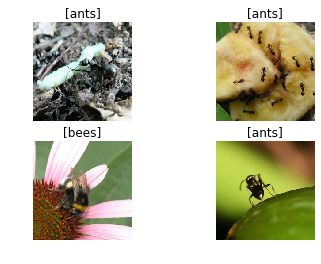

In [20]:
import torch
import matplotlib.pyplot as plt

def load_images_to_device(inputs, labels, device):
    """
    Transfer inputs and labels to the specified computing device.
    """
    return inputs.to(device), labels.to(device)

def get_predictions(model, inputs):
    """
    Predict the class labels for the given inputs using the specified model.
    """
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    return preds

def display_image(ax, input_tensor, title):
    """
    Display a single image with title on the provided Axes object.
    """
    ax.axis('off')
    ax.set_title(title)
    imshow(input_tensor)  # Assumes imshow is defined elsewhere to handle tensor to image conversion

def visualize_model(model, dataloaders, device, num_images=6, fig_name='Predictions'):
    """
    Visualize model predictions on a dataset.
    """
    images_so_far = 0
    fig = plt.figure(fig_name)
    model.eval()

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = load_images_to_device(inputs, labels, device)
            preds = get_predictions(model, inputs)

            for j in range(inputs.size()[0]):
                if images_so_far == num_images:
                    return
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                display_image(ax, inputs.cpu().data[j], '[{}]'.format(class_names[preds[j]]))

# Example usage
# Assuming 'device' is defined (e.g., device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
# and 'model_hybrid', 'dataloaders', 'class_names' are appropriately defined
visualize_model(model_hybrid, dataloaders, device, num_images=batch_size)


## References

[1] Andrea Mari, Thomas R. Bromley, Josh Izaac, Maria Schuld, and Nathan Killoran. _Transfer learning in hybrid classical-quantum neural networks_. [arXiv:1912.08278](https://arxiv.org/abs/1912.08278), (2019).

[2] Sasank Chilamkurthy. PyTorch transfer learning tutorial. https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html.

[3] Kaiming He, Xiangyu Zhang, Shaoqing ren and Jian Sun. _Deep residual learning for image recognition_.
  Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition, 770-778 (2016). [DOI: 10.1109/CVPR.2016.90]( https://doi.org/10.1109/CVPR.2016.90).
  
[4] Ville Bergholm, Josh Izaac, Maria Schuld, Christian Gogolin, Carsten Blank, Keri McKiernan, and Nathan Killoran. PennyLane: Automatic differentiation of hybrid quantum-classical computations. [arXiv:1811.04968](https://arxiv.org/abs/1811.04968), (2018).